# Linear and Random Forest models for _noisy_ regression and classification

## Comparing LinearRegression (OLS) with various RandomForestRegressors

The default Random Forest Regressor will not deal especially well with a noisy input (even if very simple) compared to a high bias (and normally quite limited) model like OLS.

Here we create a noisy single-variable linear input set and show how RF performs badly and how, by limiting its depth, we can make it perform as well as OLS

In [1]:
# install watermark using
# %install_ext https://raw.githubusercontent.com/rasbt/watermark/master/watermark.py
%load_ext watermark
# show a watermark for this environment
%watermark -d -m -v -p numpy,matplotlib,sklearn,seaborn -g

2017-10-20 

CPython 3.6.2
IPython 6.1.0

numpy 1.13.3
matplotlib 2.1.0
sklearn 0.19.0
seaborn 0.8.0

compiler   : GCC 4.8.2 20140120 (Red Hat 4.8.2-15)
system     : Linux
release    : 4.9.45-040945-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit
Git hash   : 8e057fc1df9a41891f71857500ada6aa534c5260


In [2]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import datetime

%matplotlib inline

MANY_TREES = 500 # for n_estimators in the RandomForest
SHALLOW_TREE_DEPTH = 4 # for max_depth in the RandomForest

### Build feature data

`xs` is a linear input space. `ys` is a noisy target space.

In [3]:
xs = np.arange(0, 100, 0.01, dtype=np.float_)
ys = xs.copy()

# generate Gaussian noise mean 0 variance 20
noise = np.random.normal(size=xs.shape[0], scale=20)
ys += noise

xs = xs.reshape(-1, 1) # reshape to a 2 dimensional, single column input as required by sklearn

### Show the noisy single-feature input data

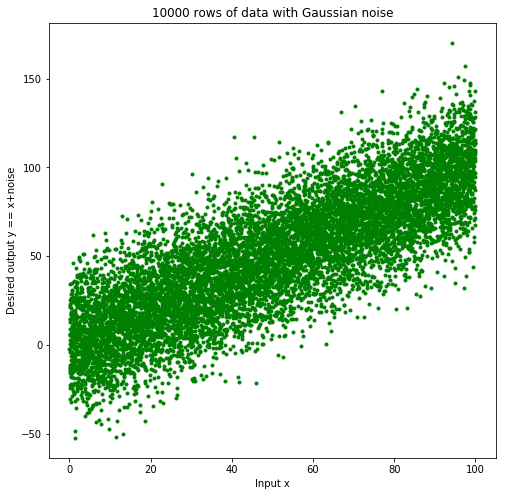

In [4]:
fig, ax = plt.subplots(figsize=(8,8));
rows = xs.shape[0]
ax.plot(xs[:, 0], ys, ".g")
ax.set_title(f"{rows} rows of data with Gaussian noise");
ax.set(xlabel="Input x", ylabel="Desired output y == x+noise");

## Create a default train/test split and train 4 estimators

In [5]:
X_train, X_test, y_train, y_test  = train_test_split(xs, ys, random_state = 0)

### LinearRegression & RF

* Linear Regression - defaults
* RandomForestRegressor - defaults (10 estimators, unlimited depth)
* RandomForestRegressor - many estimators (unlimited depth)
* RandomForestRegressor - shallow trees (default estimators)

In [6]:
ests = []
ests.append(LinearRegression())
ests.append(RandomForestRegressor())
ests.append(RandomForestRegressor(n_estimators=MANY_TREES, n_jobs=-1))
ests.append(RandomForestRegressor(max_depth=SHALLOW_TREE_DEPTH))

names = ['LinReg', 'RF_default', 'RF_many_trees', 'RF_shallow_trees']

for est in ests:
    est.fit(X_train, y_train)

predictions = []
scores = []
for est in ests:
    y_pred = est.predict(X_test)
    predictions.append(y_pred)
    score = est.score(X_test, y_test)
    scores.append([score])

est_results = pd.DataFrame.from_items(zip(names, scores), orient="index", columns=['score'])
est_results.head()

,score
LinReg,0.670143
RF_default,0.475167
RF_many_trees,0.495309
RF_shallow_trees,0.665994


## Plot X_pred (inputs in test set)  against y_pred (predicted output) for each estimator

* Linear model - high bias means a very accurate prediction (as best as can be done, given the noise level)
* RandomForestRegressor with defaults - high variance as it overfits the noisy training data
* RandomForestRegressor with many trees - slightly better but still overfits
* RandomForestRegressor with shallow trees - significant variance reduction, roughly the same performace as the linear model

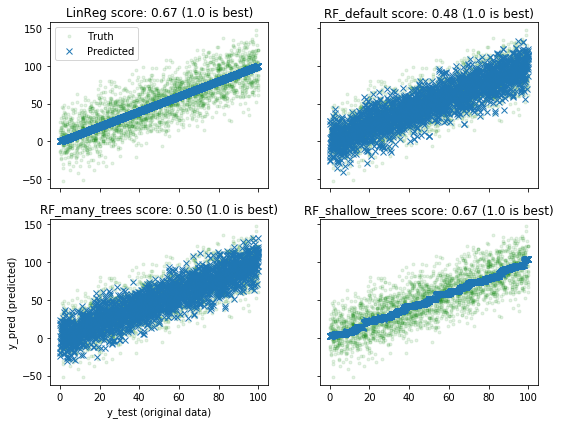

In [7]:
fig, axes = plt.subplots(figsize=(8,6), ncols=2, nrows=2, sharex=True, sharey=True);

ax0, ax1, ax2, ax3 = axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]
axs = [ax0, ax1, ax2, ax3]
for model_nbr in range(4):
    ax = axs[model_nbr]
    y_pred = predictions[model_nbr]
    score = est_results.loc[names[model_nbr]].score
    name = names[model_nbr]
    ax.plot(X_test, y_test, "g.", alpha=0.1, label="Truth")
    ax.plot(X_test, y_pred, "x", label="Predicted")
    ax.set_title(f"{name} score: {score:0.2f} (1.0 is best)");
    
    if model_nbr == 0:
        ax.legend()
    if model_nbr == 2:
        ax.set(xlabel="y_test (original data)", ylabel="y_pred (predicted)")

fig.tight_layout()

## Plot y_pred (predictions) vs y_test (desired truth)

* Linear model - predictions are between 0 & 100 (no overspill)
* RandomForestRegressor with defaults - a more 'rounded' relationship than we'd like
* RandomForestRegressor with many trees - slightly more ovoid than the defaults
* RandomForestRegressor with shallow trees - far more like the linear model outputs

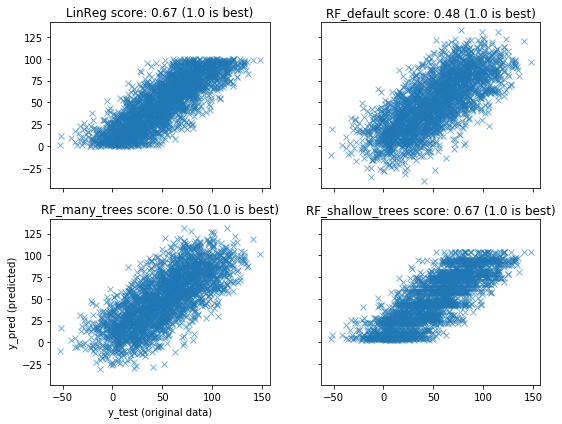

In [8]:
fig, axes = plt.subplots(figsize=(8,6), ncols=2, nrows=2, sharex=True, sharey=True);

ax0, ax1, ax2, ax3 = axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]
axs = [ax0, ax1, ax2, ax3]

for model_nbr in range(4):
    ax = axs[model_nbr]
    y_pred = predictions[model_nbr]
    score = est_results.loc[names[model_nbr]].score
    name = names[model_nbr]

    ax.plot(y_test, y_pred, "x", label=name, alpha=0.6)
    ax.set_title(f"{name} score: {score:0.2f} (1.0 is best)");

    if model_nbr == 2:
        ax.set(xlabel="y_test (original data)", ylabel="y_pred (predicted)")

fig.tight_layout()

# Solve a similar noisy problem with a 2-class classifier

If the classes are easily separated, both Logistic Regression & Random Forest will easily separate them.

If the classes overlap (especially if they overlap a lot) the high bias Logistic Regression will slightly outperform Random Forest as Random Forest will keep fitting to the noise, unless we force the trees to be shallow (so they can't make too many decisions).

In [9]:
NBR_0s = 10000 # create a balanced set of target values for a 2 class problem
NBR_1s = 10000

ys = np.zeros(shape=NBR_0s + NBR_1s)
ys[NBR_1s:] = 1

# xs is a noisy set of roughly-zero and roughly-one values, with Gaussian noise
xs = ys.copy()
noise = np.random.normal(size=xs.shape[0], scale=2)
xs += noise

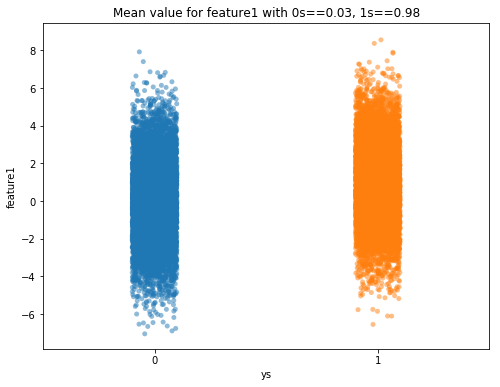

In [10]:
df_clf = pd.DataFrame({'feature1': xs, 'ys': ys.astype(np.int_)})
fig, ax = plt.subplots(figsize=(8,6));
sns.stripplot(data=df_clf, x='ys', y='feature1', jitter=True, alpha=0.5, ax=ax);

df_clf_means = df_clf.groupby('ys').mean()
df_clf_means.loc[0].feature1
title = "Mean value for feature1 with 0s=={:0.2f}, 1s=={:0.2f}".format(df_clf_means.loc[0].feature1, df_clf_means.loc[1].feature1)
ax.set(title=title);

In [11]:
xs = xs.reshape(-1, 1) # reshape to a 2 dimensional, single column input as required by sklearn
X_train, X_test, y_train, y_test  = train_test_split(xs, ys, random_state = 0)

In [12]:
clf_lr = LogisticRegression()
clf_rf_default = RandomForestClassifier()
clf_rf_many_trees = RandomForestClassifier(n_estimators=MANY_TREES, n_jobs=-1)
clf_rf_shallow_trees = RandomForestClassifier(max_depth=SHALLOW_TREE_DEPTH)

ests = [clf_lr, clf_rf_default, clf_rf_many_trees, clf_rf_shallow_trees]
names = ['LogReg', 'RF_default', 'RF_many_trees', 'RF_shallow_trees']

for est in ests:
    est.fit(X_train, y_train)

predictions = []
scores = []
for est in ests:
    y_pred = est.predict(X_test)
    predictions.append(y_pred)
    score = est.score(X_test, y_test)
    scores.append([score])

clf_results = pd.DataFrame.from_items(zip(names, scores), orient="index", columns=['Accuracy'])

## Shallow trees and LogisticRegression are comparable

* LogisticRegression - fits the noisy data 
* RandomForestRegressor with defaults - sub-optimal results due to overfitting the noise
* RandomForestRegressor with many trees - as with defaults
* RandomForestRegressor with shallow trees - as good as LogisticRegression as it cannot overfit the noise

                  Accuracy
LogReg              0.5942
RF_default          0.5424
RF_many_trees       0.5370
RF_shallow_trees    0.5958


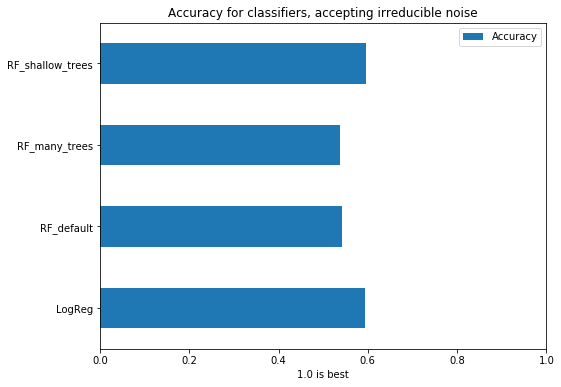

In [13]:
fig, ax = plt.subplots(figsize=(8,6));
print(clf_results.head())
clf_results.plot(kind="barh", ax=ax);
ax.set(title="Accuracy for classifiers, accepting irreducible noise", xlabel="1.0 is best", xlim=(0, 1.0));

# Completed Notebook

In [14]:
print("Completed running this Notebook at:", datetime.datetime.now())

Completed running this Notebook at: 2017-10-20 12:30:56.414469
